In [1]:
import os
import sys
import datetime

import pickle
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))
from SRModels.deep_learning_models.EDSR_model import EDSR
from SRModels.loading_methods import load_dataset_as_patches
from SRModels.constants import EDSR_PATCH_SIZE, EDSR_STRIDE, RANDOM_SEED, EDSR_SCALE_FACTOR

In [2]:
HR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/HR"))
LR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/LR"))

In [3]:
X, Y = load_dataset_as_patches(HR_ROOT, LR_ROOT, mode="scale", patch_size=EDSR_PATCH_SIZE, stride=EDSR_STRIDE, scale_factor=EDSR_SCALE_FACTOR)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (18247, 48, 48, 3), Y_train shape: (18247, 96, 96, 3)
X_val shape: (4562, 48, 48, 3), Y_val shape: (4562, 96, 96, 3)
X_test shape: (5703, 48, 48, 3), Y_test shape: (5703, 96, 96, 3)


X_train range: [0.0510, 1.0000]
Y_train range: [0.0471, 1.0000]
NaN in X_train: False, NaN in Y_train: False


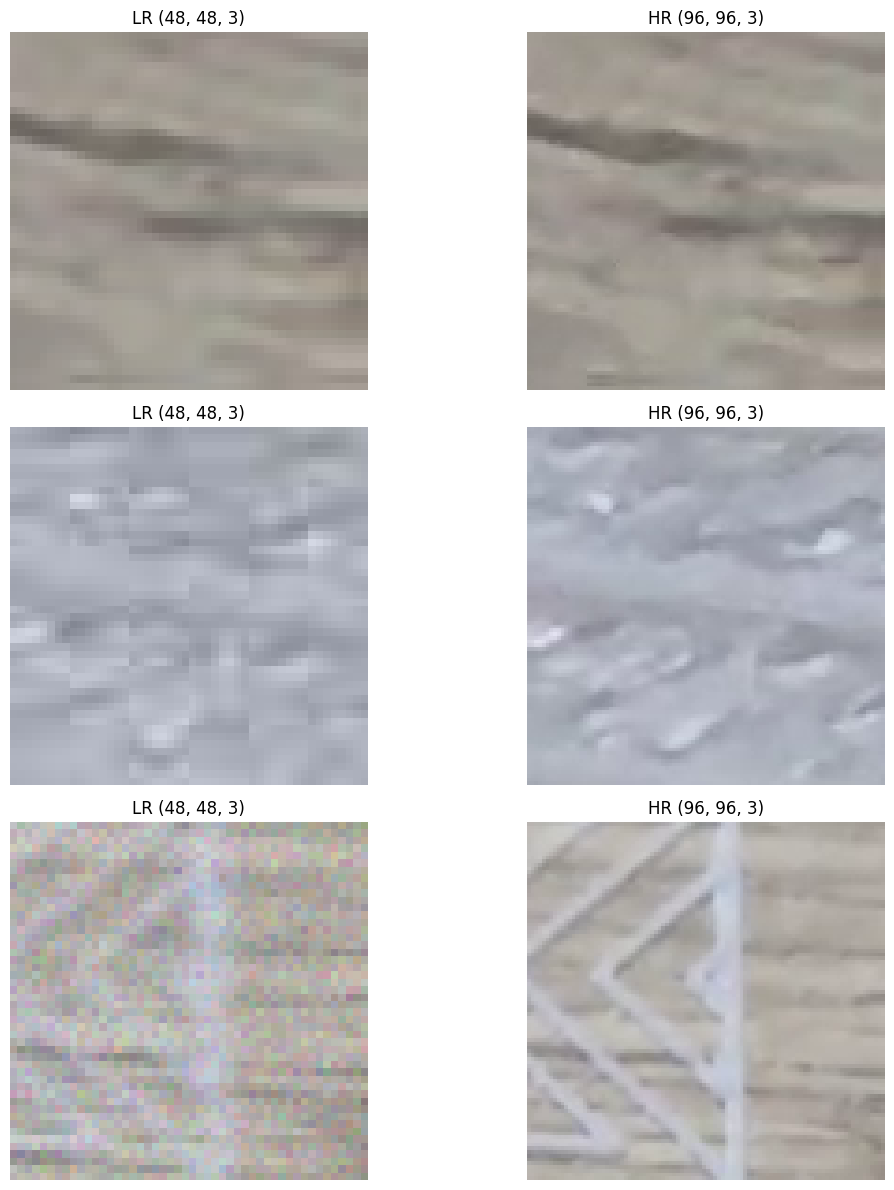

In [4]:
# Verificar rango y alineamiento de datos
import matplotlib.pyplot as plt
import numpy as np

# Verificar rangos
print(f"X_train range: [{np.min(X_train):.4f}, {np.max(X_train):.4f}]")
print(f"Y_train range: [{np.min(Y_train):.4f}, {np.max(Y_train):.4f}]")
print(f"NaN in X_train: {np.isnan(X_train).any()}, NaN in Y_train: {np.isnan(Y_train).any()}")

# Visualizar algunos pares aleatorios
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for i in range(3):
    idx = np.random.randint(0, len(X_train))
    axes[i, 0].imshow(X_train[idx])
    axes[i, 0].set_title(f"LR {X_train[idx].shape}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(Y_train[idx])
    axes[i, 1].set_title(f"HR {Y_train[idx].shape}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [5]:
model = EDSR()

model.setup_model(
    scale_factor=EDSR_SCALE_FACTOR, 
    num_res_blocks=16, 
    num_filters=64, 
    learning_rate=5e-5
)

Model: "EDSR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['input[0][0]']                  
                                64)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   36928       ['conv2d[0][0]']                 
                                64)                                                            

In [6]:
# Train EDSR and capture callbacks for metrics
time_cb, mem_cb = model.fit(
    X_train, Y_train, X_val, Y_val, 
    batch_size=16, 
    epochs=20, 
    use_augmentation=True
)

Training on GPU: /physical_device:GPU:0
Epoch 1/20
1141/1141 [==============================] - 170s 139ms/step - loss: 0.2578 - psnr: 9.8181 - ssim: 0.0875 - val_loss: 0.1681 - val_psnr: 11.5522 - val_ssim: 0.1151 - lr: 5.0000e-05 - epoch_time_sec: 169.9931 - gpu_mean_current_mb: 311.3524 - gpu_peak_mb: 1150.6252
Epoch 2/20
1141/1141 [==============================] - 148s 130ms/step - loss: 0.1654 - psnr: 11.6608 - ssim: 0.1241 - val_loss: 0.1393 - val_psnr: 12.3103 - val_ssim: 0.1430 - lr: 5.0000e-05 - epoch_time_sec: 147.9913 - gpu_mean_current_mb: 617.4243 - gpu_peak_mb: 1639.0601
Epoch 3/20
1141/1141 [==============================] - 147s 129ms/step - loss: 0.1423 - psnr: 12.3286 - ssim: 0.1423 - val_loss: 0.1373 - val_psnr: 12.4372 - val_ssim: 0.1221 - lr: 5.0000e-05 - epoch_time_sec: 146.6601 - gpu_mean_current_mb: 617.4243 - gpu_peak_mb: 1642.5793
Epoch 4/20
 802/1141 [====================>.........] - ETA: 40s - loss: 0.1404 - psnr: 12.3796 - ssim: 0.1467

KeyboardInterrupt: 

In [8]:
# Evaluate and prepare metrics dictionary
results = model.evaluate(X_test, Y_test)
metrics_dict = {
    "eval_loss": float(results[0]),
    "eval_psnr": float(results[1]),
    "eval_ssim": float(results[2]),
    "epoch_time_sec": time_cb.mean_time_value(),
    "memory": mem_cb.as_dict()
}
print(metrics_dict)

179/179 [==============================] - 8s 41ms/step - loss: 0.0243 - psnr: 30.4675 - ssim: 0.7883
Loss: 0.0243, PSNR: 30.47 dB, SSIM: 0.7883
{'eval_loss': 0.024284936487674713, 'eval_psnr': 30.467464447021484, 'eval_ssim': 0.7882868647575378, 'epoch_time_sec': 90.4569731100004, 'memory': {'gpu_mean_current_mb': 3001.0066833496094, 'gpu_peak_mb': 3613.148681640625}}


In [9]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

model.save(directory=f"models/EDSR/EDSR_{timestamp}", timestamp=timestamp)

Model saved to models/EDSR/EDSR_20250908_220847\EDSR_x2_20250908_220847.h5


In [10]:
# Save evaluation/time/memory metrics next to the model
metrics_path = os.path.abspath(os.path.join(os.getcwd(), f"models/EDSR/EDSR_{timestamp}/EDSR_{timestamp}_metrics.pkl"))

with open(metrics_path, "wb") as f:
    pickle.dump(metrics_dict, f)
    
print(f"Saved metrics to {metrics_path}")

Saved metrics to c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\EDSR\EDSR_20250908_220847\EDSR_20250908_220847_metrics.pkl
